[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeljov/NAP2025/blob/main/IE_with_LLMs_and_LangChain.ipynb)

## Information extraction (IE) via LLMs and function calling

**Information extraction** (IE) is often defined as the automated process of identifying and extracting specific, structured pieces of information from unstructured or semi-structured data sources, such as text documents, emails, reviews or medical recods (see [here](https://www.width.ai/post/emr-data-extraction) examples of such documents).
The primary goal is to transform human-readable, free-form text into a structured, machine-readable format, such as a database table or a knowledge graph, that computers can easily process and analyze.

Information extraction can be seamlessly done using LLMs that support ***function calling***, also known as ***tool calling***.

Tool calling is about providing an LLM with ability to communicate with external tools (APIs, data bases, search engines, etc). It is well explained in [OpenAI's documentation](https://platform.openai.com/docs/guides/function-calling) and the figure below, taken from that documentation, offers a nice illustration of function (tool) calling workflow:

<img src="https://cdn.openai.com/API/docs/images/function-calling-diagram-steps.png" width="470" height="630" alt="Illustration of function calling workflow">

### Our task: information extraction from customer reviews

We will use tool-calling features of an open-weights LLM available via Groq and LangChain's integration with Groq, to extract structured information from text of customer reviews.

Note: LangChain supports tool-calling for several other LLMs. A list of supported LLMs is available, for example, [here](https://python.langchain.com/docs/integrations/chat/).

We start with the regular setup steps: installing the required packages and loading the required access tokens.

In [1]:
!pip -q install langchain langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.9 MB/s eta 0:00:00


In [2]:
from os import environ
from google.colab import userdata
from langchain_groq import ChatGroq

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

RAND_STATE = 1

## Schema for information extraction and tagging

Information extraction (IE) and tagging in LangChain rely on two key components:

* **Schema**: defines what pieces of information we want to extract from the text. For example, we may want to extract the expressed sentiment, the language of the text, people and/or places mentioned in the text, etc.
* **Extraction prompt**: instructs the model how to extract information (specified in the schema) from the text; optionally, it may include examples to improve IE through few-shot learning

Both the extraction prompt and the schema are passed to an LLM. The LLM does the information extraction, following the instructions from the prompt and the meta-data embedded in the schema. It then creates and returns a JSON object aligned with the schema; LangChain parses the resulting JSON into an instance of the schema python class, as shown on the figure below:
<img src="https://drive.google.com/uc?id=13rUXdluUE_Xjo-2kCXWr879kblEc79XJ" alt="LLM-based IE Workflow"/>

The function that is called here is the function responsible for the transformation from the Schema (as a python class) to JSON Schema and from a populated JSON Schema (i.e. JSON object) to the corresponding instance (object) of the Schema (python) class.

### Defining the IE schema

There are two recommendations (best practices) to follow when defining data schema to be used in the IE task:

* *The schema and the attributes it includes should be well documented*. The information contained in the documentation is sent to the LLM and allows for improving the quality of information extraction. See, in the code below, the doc-string describing the AppReview class as well as descriptions associated to each class attribute.

* *Do not force the LLM to extract information*; othwerwise, it will make up information when it cannot extract the requested pieces. Below we use `Optional` (from python's `typing` module) when specifying attributes, thus allowing the LLM to output `None` if the requested information is not available or it cannot identify it.

### Defining data schema in Pydantic

[Pydantic](https://docs.pydantic.dev/latest/) is a Python library used for data validation and parsing.
In the following we will familiarise with the pydantic elements that are required for defining the schema of the structured output we want an LLM to produce.

`BaseModel`
* This is the core class we inherit from when defining a data schema for the structured output. Any class that inherits from BaseModel is recognized by Pydantic (and LangChain) as a data structure definition.

* Why it is relevant?

  1) **Type checking / coercion**. It automatically checks the type of the extracted data. If the LLM returns "25" for an int field, Pydantic will coerce it to the integer 25. If the LLM returns "twenty-five", Pydantic will throw a validation error, which LangChain uses to prompt the LLM to retry.
  2) **JSON Schema Generation**. Pydantic can automatically convert your Python class into a standard JSON Schema. This JSON Schema is what LangChain passes to the LLM (via function calling).

In case of using such data model in LangChain to define the expected structured output, it is recommended to add a doc string stating the purpose of the data model (schema).

In [3]:
from pydantic import BaseModel

class AppReview(BaseModel):
  """Information about a mobile app review."""
  pass

Next, pydantic allows us to define the expected data type for each field and also to specify if certain fields are optional

In [4]:
from typing import Optional

class AppReview(BaseModel):
  """Information about a mobile app review."""

  app_features: list[str]
  problems: Optional[list[str]]
  sentiment: str
  dissatisfaction: int

It also allows us to define meta-data for each field in the schema, which is highly relevant as via meta-data we are communicating additional instructions to the LLM.

The `Field` function is used to add metadata to the schema fields. Its key arguments include:
* `description`: This is key argument as it tells the LLM exactly what information to extract for this field. A good description is often the difference between a poor and a precise extraction.
* `default`: Sets a default value if the field is optional and not present in the input. It is generally recommended to make all fields optional and with a default value, to prevent LLM from halycinating to generate a field value when there is none in the input content.
* `examples`: One can provide a list of expected examples for a field, which further guides the LLM on the field's format and content. Examples are espcially useful for specifying date/time formats or any other conventions for respresenting data.



In [6]:
from pydantic import Field

class AppReview(BaseModel):
    """Information about a mobile app review."""

    app_features: Optional[list] = Field(
        default=[],
        description="The terms used in the review to describe the mobile app and its features",
        examples=[['well designed', 'very useful']]
    )

    problems: Optional[list] = Field(
        default=[],
        description="Any problems that the user mentions in the review regarding the app",
        examples=[['blinking screen', 'annoying ads']]
    )

    sentiment: Optional[str] = Field(
        default="unknown",
        description="The sentiment expressed in the review. It can be one of the following: Positive, Negative, or Neutral",
        examples=['Positive']
    )

    dissatisfaction: Optional[int] = Field(
        default=None,
        description="How dissatisfied the user is with the app, on the integer scale from 1 to 5 (higher value means higher dissatisfaction).",
        examples=[3]
    )

Finally, we can further advance the data structure by using python enums to specify allowed values for some of the fields, in this case, for the sentiment expressed in the review:

In [8]:
from enum import Enum

class Sentiment(Enum):
    NEGATIVE = "Negative"
    NEUTRAL = "Neutral"
    POSITIVE = "Positive"

class AppReview(BaseModel):
    """Information about a mobile app review."""

    app_features: Optional[list] = Field(
        default=[],
        description="The terms used in the review to describe the mobile app and its features",
        examples=[['well designed', 'very useful']]
    )

    problems: Optional[list] = Field(
        default=[],
        description="Any problems that the user mentions in the review regarding the app",
        examples=[['blinking screen', 'annoying ads']]
    )

    sentiment: Optional[Sentiment] = Field(
        default=None,
        description="The sentiment expressed in the review. It can be one of the following: Positive, Negative, or Neutral",
        examples=[Sentiment.POSITIVE]
    )

    dissatisfaction: Optional[int] = Field(
        default=None,
        description="How dissatisfied the user is with the app, on the integer scale from 1 to 5 (higher value means higher dissatisfaction).",
        examples=[3]
    )

To learn more about Pydantic, you may want to start from [this video](https://www.youtube.com/watch?v=XIdQ6gO3Anc), as it offers an excellent introduction to this python library for data typing and validation. Then, [this video tutorial](https://youtu.be/i4jespFbA1c?si=mjKneeBQdlDcQGll) and the accompanying series of blog posts (https://www.bugbytes.io/posts/introduction-to-pydantic/) allow for exploring further pydantic's features for data and code validation.


### Back to the original task: the use of LLMs for IE from text

Now that we have defined a data schema for the structured output the LLM should produce, we create an extraction prompt. As before, we are creating a prompt for a chat model and thus specify it as a list of (system and user) messages:

In [9]:
from langchain_core.prompts import ChatPromptTemplate

ie_system_msg = """
You are an expert information extraction agent, specialised in extracting information from users' comments and reviews posted on the internet.
You extract only relevant information from the text.
If you do not know the value of an attribute you've been asked to extract, return None for the attribute's value.
"""

ie_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", ie_system_msg),
        ("human", "Extract details about a customer review of a mobile app, given below.\n{text}"),
    ]
)

Next, we associate the model with the schema and combine the model with the prompt into an IE chain:


In [10]:
model_name = "llama-3.1-8b-instant"
llm = ChatGroq(model=model_name, temperature=0.0)

In [11]:
ie_llm = llm.with_structured_output(schema=AppReview) # this is where the LLM is connected w/ the Schema

ie_chain = ie_prompt_template | ie_llm

Note: the method `with_structured_output` (above) automates the process of binding the schema to the model and parsing the model's output into the structure defined by the schema.

In [12]:
reviews = [
    "not sure i feel with all the permissions you have to give this app and then you have to create an account and log in makes me believe they are using this app for getting information. it could be done with only the minable permissions and use your own memory.",
    "galaxy s2 love this app. very useful. only thing that bugs me is from time to time my screen blacks out and force closes the app when i back out.",
    "bad. has nothing for end game content and is very very very outdated."
]


Invoking the model produces structured output aligned with the given schema:

In [13]:
for review in reviews:
  print(ie_chain.invoke({'text':review}))
  print()

app_features=['create account', 'log in', 'minable permissions'] problems=['permissions', 'account creation'] sentiment=<Sentiment.NEGATIVE: 'Negative'> dissatisfaction=5
app_features=['very useful'] problems=['blinking screen', 'force closes'] sentiment=<Sentiment.NEGATIVE: 'Negative'> dissatisfaction=3
app_features=None problems=['outdated'] sentiment=<Sentiment.NEGATIVE: 'Negative'> dissatisfaction=5


### Using few-shot prompting to improve the IE results

We can try to improve the IE results by including some examples in the prompt, that is, by using few-shot prompting. For chat models, as the one we are using, this can take the form of a sequence of pairs, where each pair consists of an input and the response messages, demonstrating desired behaviors. However, creating such examples is not that easy as it is the case with 'regular' few-shot prompting, when tool calling is not involved. Here is why:

To produce structured output, the LLM we use depends, under-the-hood, on tool calling. This typically involves the generation of an AI message (one or more) containing tool calls, as well as tool messages (one or more, depending on the number of tools used) containing the results of tool calls. How exactly these messages are generated and in what order depends on the model provider (e.g., OpenAI, Google, Groq, ...).

To simplify the creation of examples for such cases, LangChain provides a utility function `tool_example_to_messages` that generates a valid sequence for most model providers. It simplifies the generation of structured few-shot examples by just requiring Pydantic representations of the expected structured output:

In [14]:
from langchain_core.utils.function_calling import tool_example_to_messages

examples = [
    (
        "cute!!!! the game is just to cute!!!! :3",
        AppReview(app_features=['cute game'], problems=[], sentiment=Sentiment.POSITIVE, dissatisfaction=1),
    ),
    (
        "amazing  well designed  but confusing. says i have a lot more free space than android reports.",
        AppReview(app_features=['well designed', 'amazing', 'confusing'], problems=['confusion about the available space'], sentiment=Sentiment.NEUTRAL, dissatisfaction=3),
    ),
    (
        "freezes every other spin crap game",
        AppReview(app_features=['crap game'], problems=['often freezes'], sentiment=Sentiment.NEGATIVE, dissatisfaction=5),
    ),
    (
        "3 stars very cute game but the ads is not cute:-):-)",
        AppReview(app_features=['very cute game', 'ads not cute'], problems=[], sentiment=Sentiment.NEUTRAL, dissatisfaction=2),
    ),
    (
        "stupid this is dumb.",
        AppReview(app_features=[], problems=[], sentiment=Sentiment.NEGATIVE, dissatisfaction=5),
    ),
    (
        "galaxy s2 love this app. very useful. only thing that bugs me is from time to time my screen blacks out and force closes the app when i back out.",
        AppReview(app_features=["very useful"], problems=['screen blacks out', 'app forced to close'], sentiment=Sentiment.POSITIVE, dissatisfaction=2),
    )
]

messages = []

for ex_txt, ex_response in examples:
    messages.extend(
        tool_example_to_messages(ex_txt, [ex_response])
    )

/tmp/ipython-input-3529639717.py:34: LangChainBetaWarning: The function `tool_example_to_messages` is in beta. It is actively being worked on, so the API may change.
  tool_example_to_messages(ex_txt, [ex_response])


Check the generated messages:

In [15]:
for message in messages:
    message.pretty_print()

================================ Human Message =================================

cute!!!! the game is just to cute!!!! :3
================================== Ai Message ==================================
Tool Calls:
  AppReview (7691338b-e1b9-4ebd-a9b6-27daebf228c9)
 Call ID: 7691338b-e1b9-4ebd-a9b6-27daebf228c9
  Args:
    app_features: ['cute game']
    problems: []
    sentiment: Positive
    dissatisfaction: 1
================================= Tool Message =================================

You have correctly called this tool.
================================ Human Message =================================

amazing  well designed  but confusing. says i have a lot more free space than android reports.
================================== Ai Message ==================================
Tool Calls:
  AppReview (d25a7a8a-70f9-4442-a991-314172c42aab)
 Call ID: d25a7a8a-70f9-4442-a991-314172c42aab
  Args:
    app_features: ['well designed', 'amazing', 'confusing']
    problems: ['confusion a

Now we can integrate the examples (represented as messages) in the prompt:

In [16]:
from langchain_core.prompts import MessagesPlaceholder

examples_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            ie_system_msg + "Please see below a few examples to help you with the information extraction task.",
        ),
        MessagesPlaceholder('examples'), # a placeholder for passing in a list of messages
        ("human", "Extract details about a customer review of a mobile app, given below.\n{text}"),
    ]
)

In [23]:
ie_examples_chain = examples_prompt_template | ie_llm

for review in reviews:
  # note that we are passing both messages that serve as examples and the review to be processed
  annotation = ie_examples_chain.invoke({'examples':messages, 'text':review})
  print(review)
  print(annotation)
  print()

not sure i feel with all the permissions you have to give this app and then you have to create an account and log in makes me believe they are using this app for getting information. it could be done with only the minable permissions and use your own memory.
app_features=[] problems=['excessive permissions', 'account creation and login required'] sentiment=<Sentiment.NEGATIVE: 'Negative'> dissatisfaction=5

galaxy s2 love this app. very useful. only thing that bugs me is from time to time my screen blacks out and force closes the app when i back out.
app_features=['love this app'] problems=['screen blacks out', 'app forced to close'] sentiment=<Sentiment.POSITIVE: 'Positive'> dissatisfaction=2

bad. has nothing for end game content and is very very very outdated.
app_features=[] problems=['outdated', 'lack of end game content'] sentiment=<Sentiment.NEGATIVE: 'Negative'> dissatisfaction=5



### Combining two schemas

We can define more than one schema and use them for extracting entites of different types - for example, about an event and people attending the event

In [18]:
from typing import List

class EventAttendee(BaseModel):
    """A person attending the event."""

    name: str = Field(
        description="Name of the attendee.")

    role: Optional[str] = Field(
        default=None,
        description="The attendee's job role or title.")


class EventDetails(BaseModel):
    """Information about a specific event."""

    title: str = Field(description="The official title of the event.")

    date: Optional[str] = Field(
        default=None,
        description="The date of the event in YYYY-MM-DD format.",
        examples=['2025-11-10'])

    location: Optional[str] = Field(
        default=None,
        description="The city and country where the event takes place.")

    attendees: List[EventAttendee] = Field(
        default=[],
        description="A list of key people attending the event.")

In [19]:
event_IE_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are an expert information extraction assistant. Extract details about the event described below."),
        ("human", "Event information: {text_input}"),
    ]
)

event_ie_llm = llm.with_structured_output(EventDetails)

event_ie_chain = event_IE_prompt | event_ie_llm

In [20]:
input_text = """
We are excited to announce the AI Frontier Summit, scheduled for 2026-03-15 in Tokyo, Japan.
Key speakers include Dr. Emily Carter, the Chief Scientist, and Mr. Alex Chen, the Lead Engineer.
"""

extracted_data = event_ie_chain.invoke({"text_input": input_text})

In [21]:
type(extracted_data)

__main__.EventDetails

In [22]:
print(f"Extracted Title: {extracted_data.title}")
print(f"Date: {extracted_data.date}")
print("Attendees:")
for attendie in extracted_data.attendees:
  print(f"\t- {attendie.name}, {attendie.role}")


Extracted Title: AI Frontier Summit
Date: 2026-03-15
Attendees:
	- Dr. Emily Carter, Chief Scientist
	- Mr. Alex Chen, Lead Engineer


### Examining the IE chain on a larger data set


To examine in more detail this kind of IE chain in the context of customer reviews we will use a data set of restaurant reviews that originates from Kaggle.com: [10000 Restaurant Reviews](https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews).<br>

We will load a bunch of restaurant reviews, extract information about what customers liked and disliked, as well as their overall sentiment and compare the latter to human labels.

First, load the data from the file

In [24]:
from google.colab import files

data_file = files.upload()

Saving Restaurant reviews.csv to Restaurant reviews.csv


The uploaded object is a dictionary having the filename and content as it’s key-value pair. So, we can extract the file name and read in the file content using pandas (to have it in the DataFrame format)

In [25]:
import pandas as pd

file_name = list(data_file.keys())[0]
data = pd.read_csv(file_name)
data.head(10)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN
5,Beyond Flavours,Nagabhavani K,"Ambiance is good, service is good, food is aPr...",5,1 Review,5/24/2019 15:22,0,NaN
6,Beyond Flavours,Jamuna Bhuwalka,"Its a very nice place, ambience is different, ...",5,1 Review,5/24/2019 1:02,0,NaN
7,Beyond Flavours,Sandhya S,Well after reading so many reviews finally vis...,4,1 Review,5/23/2019 15:01,0,NaN
8,Beyond Flavours,Akash Thorat,"Excellent food , specially if you like spicy f...",5,"1 Review , 1 Follower",5/22/2019 23:12,0,NaN
9,Beyond Flavours,Smarak Patnaik,Came for the birthday treat of a close friend....,5,"1 Review , 1 Follower",5/22/2019 22:37,0,NaN


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [27]:
# drop the columns we will not need
data.drop(columns=['Pictures','7514','Metadata'], inplace=True)

In [28]:
# drop also rows without a review
data.dropna(subset='Review', inplace=True)
data.reset_index(drop=True, inplace=True)

Compute and examine the review lenght as it does not make much sense to work with overly short reviews

In [29]:
data['ReviewLen'] = data.Review.apply(len)
data.ReviewLen.describe()

,ReviewLen
count,9955.000000
mean,279.774485
std,338.598799
min,1.000000
25%,144.000000
50%,189.000000
75%,321.000000
max,5212.000000


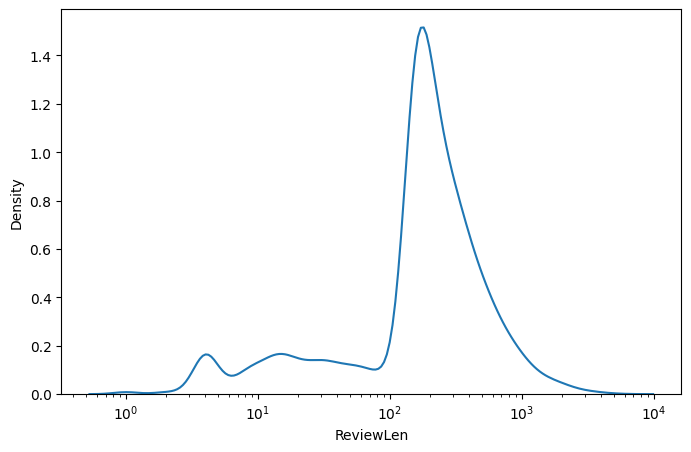

In [30]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sb.kdeplot(data=data, x='ReviewLen', log_scale=True)
plt.show()

Large majority of reviews are between 100 and 1000 characters long.

We will exclude overly short reviews (typically not much can be extracted from them), by setting aside reviews with lenght below the 10th percentile.

In [31]:
import numpy as np

tenth_perc = np.percentile(data.ReviewLen.values, 10)
# print(tenth_perc)

data_sub = data.loc[data.ReviewLen > tenth_perc,].copy()
data_sub.reset_index(drop=True, inplace=True)
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  8946 non-null   object
 1   Reviewer    8946 non-null   object
 2   Review      8946 non-null   object
 3   Rating      8946 non-null   object
 4   Time        8946 non-null   object
 5   ReviewLen   8946 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 419.5+ KB


In [ ]:
# data_sub.ReviewLen.describe()

Take a closer look at the reviews by taking a random sample from the dataset

In [32]:
for review in data_sub.Review.sample(10, random_state=RAND_STATE):
  print(review)
  print("-------------------------------------------------------------------")

The best place to enjoy punjabi food.... on weekendz its bit crowdy but on week days it is not.. i believe in hyderabad u cnt get amazing punjabi food. Moreover it is self service. Everyone must try lassi over there
Ambience 4/5
Food 5/5
-------------------------------------------------------------------
shawarma is not tasty. need to improve in taste
-------------------------------------------------------------------
Ambience was great.. food was good too.. service was pretty fast.. drinks were as I expected.. Pradhan was my appointed guy and he was very respectful and fast in delivering my orders..
-------------------------------------------------------------------
Ask anyone what you like about Hyderabad the most, the answer is always Food! Hyderabadi food has played a pivotal role in making the city one of the most culturally diverse cities in India! Irrespective of which state you are and kind of palate you have, Hyderabadi food will make its way to your heart with its rich genero

In [33]:
# make the review content more compact by eliminating multiple lines
data_sub['Review'] = data_sub.Review.apply(lambda rev: rev.replace("\n", " "))

Add the 'Sentiment' column based on the customer ratings:

In [34]:
data_sub.Rating.value_counts()

,count
Rating,
5,3148
4,2255
1,1635
3,1120
2,643
4.5,69
3.5,47
2.5,19
1.5,9


In [35]:
data_sub = data_sub.loc[data_sub.Rating != 'Like',]

def sentiment(rating:float) -> str:
  if float(rating) < 3: return "negative"
  return "positive" if float(rating) > 3 else "neutral"

data_sub['Rating2Sntmt'] = data_sub.Rating.apply(sentiment)
data_sub.Rating2Sntmt.value_counts()

,count
Rating2Sntmt,
positive,5519
negative,2306
neutral,1120


Now, define the schema for IE from restaurant reviews

In [36]:
class RestaurantReview(BaseModel):
    """Information about customer opinions and sentiment expressed in a restaurant review."""

    sentiment: Optional[str] = Field(
        default=None,
        description="The overall sentiment expressed in the review. Possible options are: positive, negative, neutral",
        examples=['positive']
    )

    food_positives: Optional[list] = Field(
        default=[],
        description="Positive opinion(s) and satisfaction expressed in the review about the food served in the restaurant. This field is about food only and no other aspects of the restaurant.",
        examples=["amazing punjabi food"]
    )

    other_positives: Optional[list] = Field(
        default=[],
        description="Positive opinion(s) and satisfaction expressed in the review about the restaurant itself, including, for example, its facilites, staff, and atmosphere. This field is about the customer's positive perceptions of various aspects of the restaurant EXCEPT food.",
        examples=["service was quick", "staff did their best"]
    )

    food_negatives: Optional[list] = Field(
        default=[],
        description="Negative opinion(s) and dissatisfaction expressed in the review about the food served in the restaurant. This field is about food only and no other aspects of the restaurant.",
        examples=["stale chicken", "cold roties"]
    )

    other_negatives: Optional[list] = Field(
        default=[],
        description="Negative opinion(s) and dissatisfaction expressed in the review about the restaurant itself, including, for example, its facilites, staff, and atmosphere. This field is about the customer's negative perceceptions about various aspects of the restaurant EXCEPT food.",
        examples=["long waiting to be served"]
    )



We can use the same IE prompt template as the one above (`ie_prompt_template`), but we need to instiate an LLM with a different IE schema:

In [37]:
llm = ChatGroq(model=model_name, temperature=0.1)
restaurant_ie_llm = llm.with_structured_output(schema=RestaurantReview)


restaurant_ie_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", ie_system_msg),
        ("human", "Extract details about a restaurant review, given below:\n{text}"),
    ]
)

restaurant_ie_chain = restaurant_ie_prompt_template | restaurant_ie_llm

First, try the IE chain on a few reviews only

In [38]:
import textwrap

restaturant_reviews_sample = data_sub.Review.sample(3, random_state=RAND_STATE).to_list()
for review in restaturant_reviews_sample:
  response = restaurant_ie_chain.invoke({'text': review})
  print(textwrap.fill(review, width=100))
  print()
  print("Extracted info:")
  print(f"Overall sentiment: {response.sentiment}")
  print(f"Positive food-related comments: {response.food_positives}")
  print(f"Negative food-related comments: {response.food_negatives}")
  print(f"Other positive comments: {response.other_positives}")
  print(f"Other negative comments: {response.other_negatives}")
  print("-----------------------------------------------------------------------")

you wanna dance with these crazy people around! get in 👍 loud music inside.. so I like it outside..
nice open area.. be there if you're looking for some place in Gachibowli otherwise I'd prefer
Jubilee or Banjara ☝️  Food - 2.5/5 Service - 3/5 Ambience - 2.5/5 People - 2.5/5

Extracted info:
Overall sentiment: neutral
Positive food-related comments: ['nice open area']
Negative food-related comments: ['stale food']
Other positive comments: ['nice open area']
Other negative comments: ['loud music']
-----------------------------------------------------------------------
One of the best Baker shops in the city. I tasted several 🍰 from this place and every time it met my
expectations. I also order grilled chicken sandwich, chicken burger, egg puff from here. Every time
foods were yummy.  Food 4.5/5

Extracted info:
Overall sentiment: positive
Positive food-related comments: ['yummy', 'met my expectations']
Negative food-related comments: None
Other positive comments: None
Other negative com

Considering the restrictions on the Groq API use, instead of tagging all reviews in our data subset, we will just demonstrate the process on a small sample.
Since the dataset is biased towards positive reviews, to explore how the model is able to deal with all three kinds of sentiment, we will randomly take 20 reviews from each sentiment category:

In [39]:
sample_size = 20
rand_state = RAND_STATE

pos_sample = data_sub.loc[data_sub.Rating2Sntmt=='positive'].sample(sample_size, random_state=rand_state)
neg_sample = data_sub.loc[data_sub.Rating2Sntmt=='negative'].sample(sample_size, random_state=rand_state)
neutral_sample = data_sub.loc[data_sub.Rating2Sntmt=='neutral'].sample(sample_size, random_state=rand_state)

review_sample = pd.concat([pos_sample, neg_sample, neutral_sample], axis=0, ignore_index=True)
review_sample = review_sample.sample(frac=1, ignore_index=True) # shuffle all rows
review_sample.head()

,Restaurant,Reviewer,Review,Rating,Time,ReviewLen,Rating2Sntmt
0,Jonathan's Kitchen - Holiday Inn Express & Suites,Umesh Kumar,I had recently been to Jonathan's Kitchen base...,3,1/13/2019 12:12,234,neutral
1,The Lal Street - Bar Exchange,Rupam Das,"The rooftop of the place is quite good. But, o...",3,4/28/2019 19:11,147,neutral
2,Squeeze @ The Lime,Srinivas,"We had a good experience food was super , Ambi...",4,7/16/2018 12:08,174,positive
3,Shah Ghouse Hotel & Restaurant,Raparthi Shekar,I have ordered through Zomato 1 chicken and 1 ...,1,3/23/2019 6:05,228,negative
4,Al Saba Restaurant,Ankit Garhwal,"Visited here n had chicken biryani 5/5, kolhap...",4.5,11/1/2017 0:58,183,positive


Now, we can pass each review to the IE chain and structure the results into a data frame for easier later integration with the reviews samples

In [40]:
from time import sleep

def llm_tagging(review:str) -> tuple:
  try:
    return restaurant_ie_chain.invoke({"text":review})
  except Exception as e:
    print(f"Error when processing review \"{review}\":\n{e}")
    return None
  finally:
    sleep(3)


tagging_results = []
for i, review in enumerate(review_sample.Review.tolist()):

  if i % 10 == 0: print(f"Processing {i+1}. review")

  res = llm_tagging(review)
  tagging_results.append({
      'sentiment': res.sentiment if res else None,
      'food_positives': res.food_positives if res else None,
      'food_negatives': res.food_negatives if res else None,
      'other_positives': res.other_positives if res else None,
      'other_negativess': res.other_negatives if res else None
  })


tagging_res_df = pd.DataFrame(tagging_results)

Processing 1. review
Processing 11. review
Processing 21. review
Processing 31. review
Processing 41. review
Error when processing review "Useless.. They serve alakarte items as "prasadam" and empty customer pockets. It's not worthy. Quality and quantity is poor. Once you visit then you will never visit there in your life time. I dont recommend other customers to go here. Jaagao grhak jaago..":
Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=RestaurantReview> {"name": "restaurant review", "food_negatives": ["poor quality", "poor quantity"], "other_negatives": ["empty customer pockets", "not worthy", "once you visit then you will never visit there in your life time", "I dont recommend other customers to go here"], "other_positives": [None], "sentiment": "negative"} </function>'}}
Processing 51. review


In [41]:
tagging_res_df.head(10)

,sentiment,food_positives,food_negatives,other_positives,other_negativess
0,negative,[],[average in quality],[],"[average for the price what they charge, not g..."
1,negative,[],[],[the rooftop of the place is quite good],"[the place is small, overcrowded, little place..."
2,positive,[super],[stale chicken],"[ambience good, hospitality, visit again]",[washroom not properly cleaned]
3,negative,[],"[Egg biryani, taste of the Chicken biryani is ...",[],[second instance happened]
4,positive,"[amazing gravy based, good rotis]",None,[service was quick],None
5,negative,None,None,None,"[long waiting to be served, stinks, waiters wi..."
6,positive,[delicious food],[],"[ambience is very good, staff are very nice, g...",[]
7,mixed,[tasted good],"[over priced, quantity was very small compared...","[nice cozy ambience, good place to have coffee...",[over priced]
8,positive,"[amazing, on point]",[],[will definitely visit again with a happy face],[]
9,positive,[amazing food],[],"[amazing service, service was amazing]",[]


In [42]:
tagged_review_sample = pd.concat([review_sample, tagging_res_df], axis=1)
tagged_review_sample.head()

,Restaurant,Reviewer,Review,Rating,Time,ReviewLen,Rating2Sntmt,sentiment,food_positives,food_negatives,other_positives,other_negativess
0,Jonathan's Kitchen - Holiday Inn Express & Suites,Umesh Kumar,I had recently been to Jonathan's Kitchen base...,3,1/13/2019 12:12,234,neutral,negative,[],[average in quality],[],"[average for the price what they charge, not g..."
1,The Lal Street - Bar Exchange,Rupam Das,"The rooftop of the place is quite good. But, o...",3,4/28/2019 19:11,147,neutral,negative,[],[],[the rooftop of the place is quite good],"[the place is small, overcrowded, little place..."
2,Squeeze @ The Lime,Srinivas,"We had a good experience food was super , Ambi...",4,7/16/2018 12:08,174,positive,positive,[super],[stale chicken],"[ambience good, hospitality, visit again]",[washroom not properly cleaned]
3,Shah Ghouse Hotel & Restaurant,Raparthi Shekar,I have ordered through Zomato 1 chicken and 1 ...,1,3/23/2019 6:05,228,negative,negative,[],"[Egg biryani, taste of the Chicken biryani is ...",[],[second instance happened]
4,Al Saba Restaurant,Ankit Garhwal,"Visited here n had chicken biryani 5/5, kolhap...",4.5,11/1/2017 0:58,183,positive,positive,"[amazing gravy based, good rotis]",None,[service was quick],None


Check the level of matching between human labels and the labels assigned by the LLM:

In [43]:
from statistics import mean

def label_match(row):
  human_lbl = row['Rating2Sntmt']
  llm_lbl = "other" if not row['sentiment'] else row['sentiment']
  return human_lbl == llm_lbl

sentiment_match = tagged_review_sample.apply(label_match, axis=1)
print(f"Number of matched labels: {sum(sentiment_match)}")
print(f"Proportion of matched labels: {mean(sentiment_match):.4f}")

Number of matched labels: 44
Proportion of matched labels: 0.7333


We should explore where mismatches are and try to understand why the tagging was wrongly done

In [44]:
tagged_review_sample['sentiment_matched'] = sentiment_match
tagged_review_sample.loc[~tagged_review_sample.sentiment_matched, ['Review', 'Rating2Sntmt', 'sentiment']]

,Review,Rating2Sntmt,sentiment
0,I had recently been to Jonathan's Kitchen base...,neutral,negative
1,"The rooftop of the place is quite good. But, o...",neutral,negative
7,"Nice cozy ambience, good place to have coffee ...",negative,mixed
10,pulav packaging should be improved.,positive,negative
14,I have received one gulab jamun only wherever ...,neutral,negative
18,Ambience is good and food is not that great. W...,neutral,negative
26,Food is good but paking is worst,neutral,negative
32,Order regular paneer tikka briyani from this p...,neutral,negative
33,I have visited this place for team lunch.. We ...,neutral,negative
35,food was delivered cold,neutral,negative


Mixed results - for some reviews, the LLM was clearly wrong, but there are also cases where the sentiment it assigned looks more appropriate than the one determined by the customer scores

In [45]:
tagged_review_sample.sentiment.value_counts()

,count
sentiment,
negative,32
positive,19
neutral,7
mixed,1


It seems that the model has a bias towards negative sentiment.

### To explore further:

#### Knowedge graph extraction

An interesting thing to explore further is the use of LangChain for the extraction of a knowledge graph from the given textual content. This is a more advanced form of information extraction since it includes extracting entities mentioned in the text and their relationships, followed by the creation of a graph out of the extracted information (nodes are the identified entities, whereas edges are the relationships identified among the entities).

For an example how it can be done, check the code and the tutorial at this GitHub repo: [https://github.com/thu-vu92/knowledge-graph-llms/](https://github.com/thu-vu92/knowledge-graph-llms/)

#### LangExtract

In addition, Google's [LangExtract](https://github.com/google/langextract) library is anther LLM-based option for IE extraction, which seems to be more promising (that is, allow for more precise IE) than the approach presented here.